In [1]:
import copy
import itertools
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from pynufft import NUFFT
from scipy import signal as sci_signal
from scipy import stats
from scipy.constants import c
from scipy.stats import median_abs_deviation, norm

from csromer.base import Dataset
from csromer.dictionaries import DiscreteWavelet, UndecimatedWavelet
from csromer.io import Reader, Writer
from csromer.objectivefunction import L1, TSV, TV, Chi2, OFunction
from csromer.optimization import ADMM, FISTA, SDMM, GradientBasedMethod
from csromer.reconstruction import Parameter
from csromer.simulation import FaradayThickSource, FaradayThinSource
from csromer.transformers import DFT1D, NUFFT1D, Gridding
from csromer.utils import Gaussian, complex_to_real, real_to_complex

In [2]:
def chi2_calc(residuals):
    if residuals.dtype == np.complex64 or residuals.dtype == np.complex128:
        data = (residuals.real * residuals.real) + (residuals.imag * residuals.imag)
    else:
        data = residuals**2
    return np.sum(data)

In [3]:
def aicbic(residuals_coeffs, x_coeffs):
    rss = chi2_calc(residuals)
    if x.dtype == np.complex64 or x.dtype == np.complex128:
        df = np.count_nonzero(x.real) + np.count_nonzero(x.imag)
    else:
        df = np.count_nonzero(x)
    l = len(residuals)
    return l * np.log(rss / l) + 2 * df, l * np.log(rss / l) + df * np.log(l)

In [4]:
def aicbic(residuals, x):
    rss = chi2_calc(residuals)
    if x.dtype == np.complex64 or x.dtype == np.complex128:
        df = np.count_nonzero(x.real) + np.count_nonzero(x.imag)
        lcoeffs = 2 * len(x)
    else:
        df = np.count_nonzero(x)
        lcoeffs = len(x)
    l = len(residuals)
    print("len(coeffs):", lcoeffs)
    print("l:", l)
    print("df:", df)
    print("rss:", rss)
    print("rss/l", rss / l)
    print("log(rss/l)", np.log(rss / l))
    print("log(l)", np.log(l))
    return l * np.log(rss / l) + 2 * df, l * np.log(rss / l) + df * np.log(l)

In [5]:
np.random.seed(666)

In [6]:
# JVLA 1.008e9 2.031e9 1000
nu = np.linspace(start=1.008e9, stop=2.031e9, num=1000)  # VLA
#nu = np.linspace(start=0.89e9, stop=1.681e9, num=1000) # MeerKAT
#nu = np.linspace(start=0.58e9, stop=2.50e9, num=512)

In [7]:
peak_thinsource = 0.0035
peak_thicksource = 0.0035

In [8]:
thinsource = FaradayThinSource(nu=nu, s_nu=peak_thinsource, phi_gal=-200, spectral_idx=0.0)

In [9]:
#140 JVLA
# 95 MeerKAT
thicksource = FaradayThickSource(
    nu=nu, s_nu=peak_thicksource, phi_fg=140, phi_center=200., spectral_idx=0.0
)

In [10]:
thinsource.l2_ref = thinsource.calculate_l2ref()

In [11]:
thicksource.l2_ref = thicksource.calculate_l2ref()

In [12]:
thinsource.simulate()
thicksource.simulate()

In [13]:
simsource = thinsource + thicksource

In [14]:
simsource.l2_ref = simsource.calculate_l2ref()

In [15]:
simsource.l2_ref

0.04391188387444095

In [16]:
original_source = copy.deepcopy(simsource)

In [17]:
remove_channels_seed = int(time.time())
remove_channels_seed

1656347262

In [18]:
#simsource.remove_channels(0.1, np.random.RandomState(1648643337))
#simsource.remove_channels(0.1, np.random.RandomState(1648650067))
simsource.remove_channels(0.2)

In [19]:
peak_thinsource

0.0035

In [20]:
applied_noise = 0.2 * peak_thinsource

In [21]:
applied_noise * 1000.0

0.7000000000000001

In [22]:
#simsource.data = np.random.normal(loc=0.0, scale=applied_noise, size=simsource.m) + 1j * np.random.normal(loc=0.0, scale=applied_noise, size=simsource.m)

In [23]:
simsource.apply_noise(applied_noise)

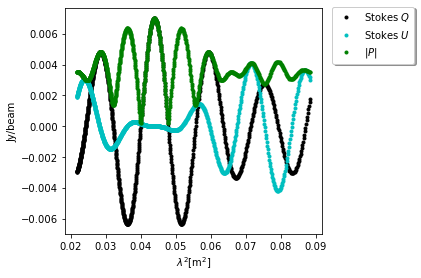

In [24]:
plt.plot(original_source.lambda2, original_source.data.real, 'k.', label=r"Stokes $Q$")
plt.plot(original_source.lambda2, original_source.data.imag, 'c.', label=r"Stokes $U$")
plt.plot(original_source.lambda2, np.abs(original_source.data), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
plt.legend(loc=(1.04, 0.755), fancybox=True, shadow=True)
plt.tight_layout()
#plt.ylim([-0.01,0.01])
#plt.savefig("pol_sim1.png", dpi=100)

In [25]:
np.max(np.abs(original_source.data))

0.0069998261578643195

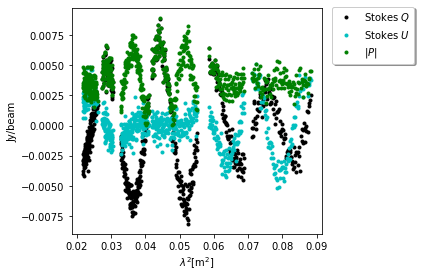

In [26]:
plt.plot(simsource.lambda2, simsource.data.real, 'k.', label=r"Stokes $Q$")
plt.plot(simsource.lambda2, simsource.data.imag, 'c.', label=r"Stokes $U$")
plt.plot(simsource.lambda2, np.abs(simsource.data), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
plt.legend(loc=(1.04, 0.755), fancybox=True, shadow=True)
plt.tight_layout()
#plt.ylim([-0.01,0.01])
#plt.savefig("pol_sim1.png", dpi=100)

In [27]:
(simsource.m / original_source.m) * 100

80.0

In [28]:
sigma_qu = 0.5 * (np.std(simsource.data.real) + np.std(simsource.data.imag))
sigma_qu

0.0028512261034522503

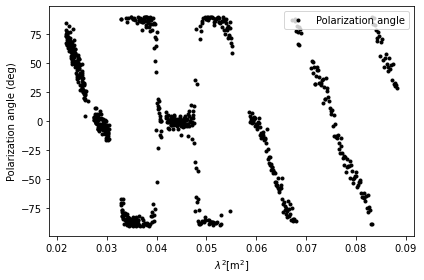

In [29]:
import astropy.units as u

plt.plot(
    simsource.lambda2,
    simsource.calculate_polangle('data').to(u.deg),
    'k.',
    label=r"Polarization angle"
)
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Polarization angle (deg)')
plt.legend(loc='upper right')
plt.tight_layout()

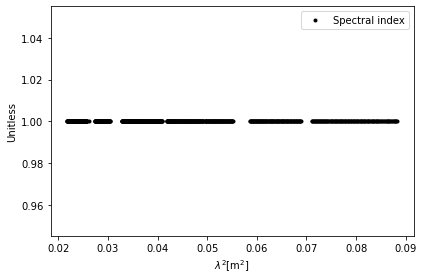

In [30]:
plt.plot(simsource.lambda2, simsource.s, 'k.', label=r"Spectral index")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Unitless')
plt.legend(loc='upper right')
plt.tight_layout()

In [31]:
dataset = simsource

In [32]:
parameter = Parameter()
original_parameter = Parameter()

In [33]:
original_parameter.calculate_cellsize(dataset=original_source, oversampling=8)

FWHM of the main peak of the RMTF: 51.962 rad/m^2
Maximum recovered width structure: 144.188 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 25954.896


In [34]:
parameter.calculate_cellsize(dataset=dataset, oversampling=8)

FWHM of the main peak of the RMTF: 52.102 rad/m^2
Maximum recovered width structure: 144.188 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 20814.748


In [35]:
nufft = NUFFT1D(dataset=dataset, parameter=parameter, solve=True)

In [36]:
dft = DFT1D(dataset=dataset, parameter=parameter)
dft_original = DFT1D(dataset=original_source, parameter=original_parameter)

In [37]:
F_dirty = dft.backward(dataset.data)
F_dirty_original = dft_original.backward(original_source.data)

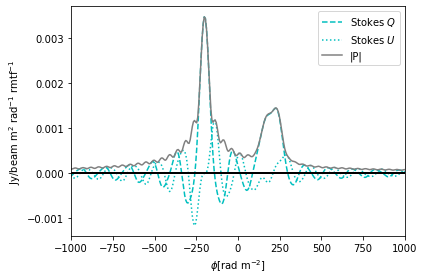

In [38]:
plt.plot(original_parameter.phi, F_dirty_original.real, 'c--', label=r"Stokes $Q$")
plt.plot(original_parameter.phi, F_dirty_original.imag, 'c:', label=r"Stokes $U$")
plt.plot(original_parameter.phi, np.abs(F_dirty_original), '-', c='grey', label=r"|P|")
#plt.plot([-200., -200.], [0., 0.0035], ls='-', lw=2., c='black')
plt.plot(original_parameter.phi, np.zeros(len(original_parameter.phi)), ls='-', lw=2., c='black')
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000, 1000])
plt.tight_layout()
#plt.savefig("fds_sim1.png", dpi=100)

In [39]:
np.max(np.abs(original_source.data)) / np.max(np.abs(F_dirty_original))

2.0099375248300415

In [40]:
# 1/(np.sqrt(original_source.m*np.pi)/(original_source.phi_fg))

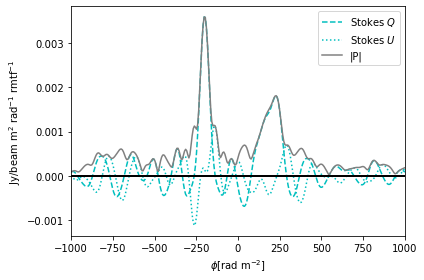

In [41]:
plt.plot(parameter.phi, F_dirty.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_dirty.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_dirty), '-', c='grey', label=r"|P|")
#plt.plot([-200., -200.], [0., 0.0035], ls='-', lw=2., c='black')
plt.plot(parameter.phi, np.zeros(len(parameter.phi)), ls='-', lw=2., c='black')
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000, 1000])
plt.tight_layout()
#plt.savefig("fds_sim1.png", dpi=100)

In [42]:
idx_noise = np.where(np.abs(parameter.phi) > 0.8 * parameter.max_faraday_depth)
noise_F = 0.5 * (
    median_abs_deviation(F_dirty[idx_noise].real, scale="normal") +
    median_abs_deviation(F_dirty[idx_noise].imag, scale="normal")
)
noise_F

6.126151678708537e-05

In [43]:
dataset.theo_noise

2.4748737341529167e-05

In [44]:
noise_from_w = 1.0 / np.sqrt(np.sum(dataset.w))
noise_from_w * 1000.0

0.024748737341529166

In [45]:
F_back = dft.backward(dataset.data)

(-1000.0, 1000.0)

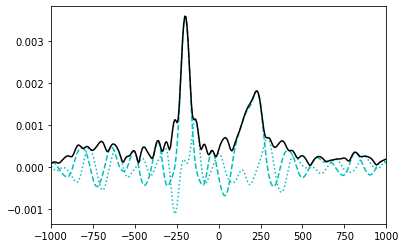

In [46]:
plt.plot(parameter.phi, F_back.real, 'c--', label=r"Real part")
plt.plot(parameter.phi, F_back.imag, 'c:', label=r"Imaginary part")
plt.plot(parameter.phi, np.abs(F_back), 'k-', label=r"Amplitude")
plt.xlim([-1000, 1000])

In [47]:
wav = None
#wav = DiscreteWavelet(wavelet_name="coif3", mode="periodization", append_signal=False)
#wav = UndecimatedWavelet(wavelet_name="sym2", mode="periodization", append_signal=True)

In [48]:
parameter.data = F_dirty
parameter.complex_data_to_real()
if wav is not None:
    print(wav.calculate_max_level(parameter.data))
    parameter.data = wav.decompose(parameter.data)
    if wav.append_signal is True:
        parameter.data[0:2 * len(F_dirty)] = 0.0
    plt.plot(parameter.data)

In [49]:
len(parameter.data)

12736

In [50]:
np.sqrt(2) * np.mean(dataset.sigma) * 1000.0

0.9899494936611668

In [51]:
#lambda_l1 = np.sqrt(2*dataset.m + (4*np.sqrt(2*dataset.m))) * dataset.theo_noise
#lambda_l1 = np.sqrt(dataset.m + (2*np.sqrt(2*dataset.m))) * np.sqrt(2) * dataset.theo_noise
#lambda_l1 = np.sqrt(dataset.m) * noise_F
if wav is not None:
    lambda_l1 = np.sqrt(dataset.m +
                        2 * np.sqrt(dataset.m)) * 2. * np.sqrt(2) * np.mean(dataset.sigma)
else:
    lambda_l1 = np.sqrt(dataset.m + 2 * np.sqrt(dataset.m)) * np.sqrt(2) * np.mean(dataset.sigma)
#lambda_l1 = np.sqrt(dataset.m) * noise_F
#print(lambda_l1)
#lambda_l1 /= 2
#lambda_l1=0.5
lambda_tsv = 0.0
chi2 = Chi2(dft_obj=nufft, wavelet=wav)
l1 = L1(reg=lambda_l1)
tsv = TSV(reg=lambda_tsv)
# F_func = [chi2(P, dft, W), L1(lambda_l1)]
F_func = [chi2, l1]
f_func = [chi2]
g_func = [l1]

F_obj = OFunction(F_func)
f_obj = OFunction(f_func)
g_obj = OFunction(g_func)

In [52]:
lambda_l1

0.028973042153785395

In [53]:
if wav is not None:
    opt = FISTA(
        guess_param=parameter,
        F_obj=F_obj,
        fx=chi2,
        gx=g_obj,
        noise=2.0 * dataset.theo_noise,
        verbose=False
    )
else:
    opt = FISTA(
        guess_param=parameter,
        F_obj=F_obj,
        fx=chi2,
        gx=g_obj,
        noise=dataset.theo_noise,
        verbose=False
    )
#opt = FISTA(i_guess=F_real, F_obj=F_obj, fx=chi2, gx=g_obj, maxiter=1000, noise=1e-5, verbose=True)
obj, X = opt.run()
print(obj)

776.377787107917


In [54]:
if wav is not None:
    plt.plot(X.data)

In [55]:
if wav is not None:
    X.data = wav.reconstruct(X.data)
X.real_data_to_complex()

(-1000.0, 1000.0)

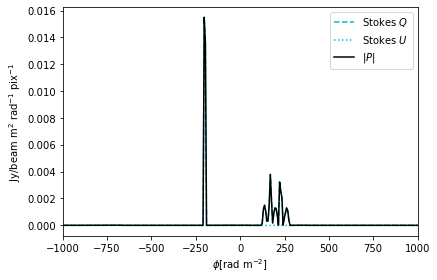

In [56]:
plt.plot(parameter.phi, X.data.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, X.data.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(X.data), 'k-', label=r"$|P|$")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ pix$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlim([-1000, 1000])

In [57]:
model_data_2 = nufft.forward_normalized(X.data)

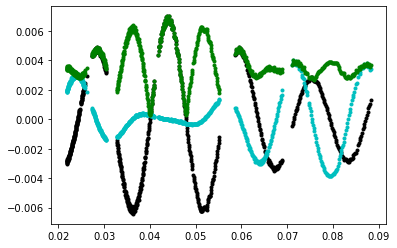

In [58]:
plt.plot(dataset.lambda2, dataset.model_data.real, 'k.', label=r"Stokes $Q$")
plt.plot(dataset.lambda2, dataset.model_data.imag, 'c.', label=r"Stokes $U$")
plt.plot(dataset.lambda2, np.abs(dataset.model_data), 'g.', label=r"$|P|$")

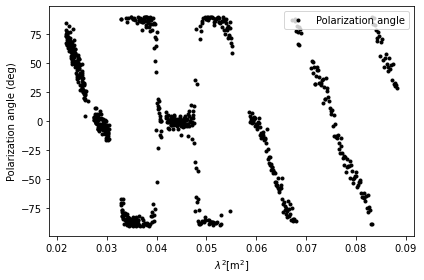

In [59]:
plt.plot(
    dataset.lambda2,
    dataset.calculate_polangle('model_data').to(u.deg),
    'k.',
    label=r"Polarization angle"
)
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Polarization angle (deg)')
plt.legend(loc='upper right')
plt.tight_layout()

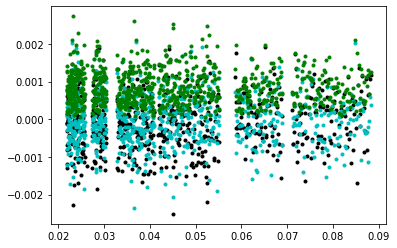

In [60]:
plt.plot(dataset.lambda2, dataset.residual.real, 'k.', label=r"Stokes $Q$")
plt.plot(dataset.lambda2, dataset.residual.imag, 'c.', label=r"Stokes $U$")
plt.plot(dataset.lambda2, np.abs(dataset.residual), 'g.', label=r"$|P|$")

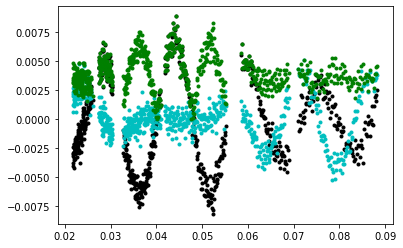

In [61]:
plt.plot(dataset.lambda2, dataset.data.real, 'k.', label=r"Stokes $Q$")
plt.plot(dataset.lambda2, dataset.data.imag, 'c.', label=r"Stokes $U$")
plt.plot(dataset.lambda2, np.abs(dataset.data), 'g.', label=r"$|P|$")

In [62]:
sigma_res = 0.5 * (np.std(dataset.residual.real) + np.std(dataset.residual.imag))

In [63]:
sigma_res * 1000.0

0.6888058545549719

In [64]:
F_residual = dft.backward(dataset.residual)

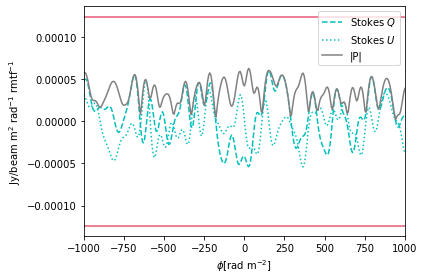

In [65]:
plt.plot(parameter.phi, F_residual.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_residual.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_residual), '-', c='grey', label=r"|P|")
#plt.plot([-200.,-200.],[0.,0.0035],ls='-',lw=2.,c='black')
#plt.plot(parameter.phi,np.zeros(len(parameter.phi)),ls='-',lw=2.,c='black')
plt.axhline(y=5 * dataset.theo_noise, color='crimson', alpha=0.7)
plt.axhline(y=-5 * dataset.theo_noise, color='crimson', alpha=0.7)
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000, 1000])
plt.tight_layout()
#plt.savefig("fds_sim1.png", dpi=100)

In [66]:
rms_residual = 0.5 * (np.std(F_residual.real) + np.std(F_residual.imag))
rms_residual * 1000.0

0.023816564862499945

In [67]:
dataset.theo_noise * 1000.0

0.024748737341529166

In [68]:
noise_F * 1000.0

0.06126151678708537

In [69]:
applied_noise * 1000.0

0.7000000000000001

In [70]:
sigma_qu * 1000.0

2.8512261034522504

In [71]:
model_2 = dft.backward(dataset.model_data)

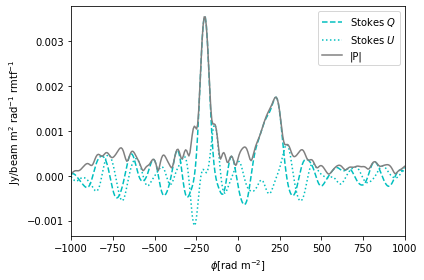

In [72]:
plt.plot(parameter.phi, model_2.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, model_2.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(model_2), '-', c='grey', label=r"|P|")
#plt.plot([-200.,-200.],[0.,0.0035],ls='-',lw=2.,c='black')
#plt.plot(parameter.phi,np.zeros(len(parameter.phi)),ls='-',lw=2.,c='black')
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000, 1000])
plt.tight_layout()
#plt.savefig("fds_sim1.png", dpi=100)

In [73]:
residual_faraday = F_dirty - model_2

In [74]:
conv_model = X.convolve() + F_residual

In [75]:
SMALL_SIZE = 17
MEDIUM_SIZE = 18
BIGGER_SIZE = 19

plt.rcParams.update(
    {
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.texsystem": 'pdflatex',  # default is xetex
    }
)

plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize

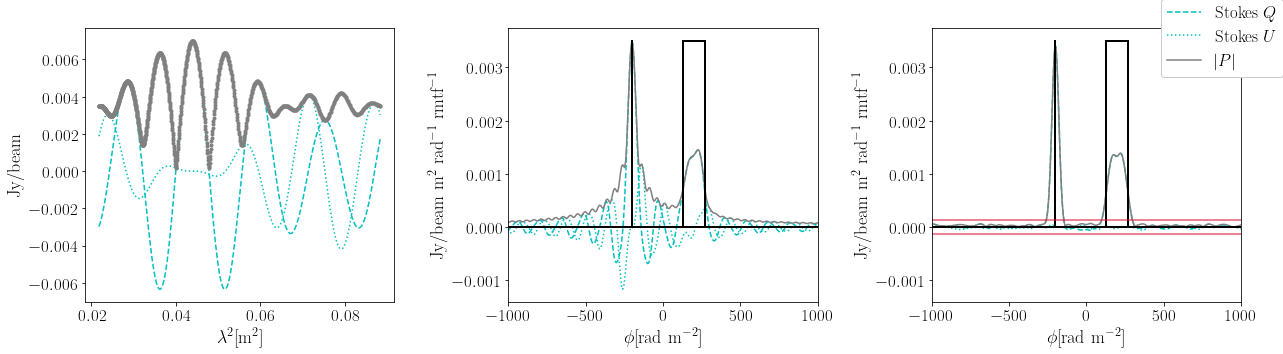

In [76]:
fig = plt.figure(figsize=(18, 5))
#fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(original_source.lambda2, original_source.data.real, 'c--', label=r"Stokes $Q$")
ax1.plot(original_source.lambda2, original_source.data.imag, 'c:', label=r"Stokes $U$")
ax1.plot(original_source.lambda2, np.abs(original_source.data), '.', color="grey", label=r"$|P|$")
ax1.set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax1.set_ylabel(r'Jy/beam')

ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(original_parameter.phi, F_dirty_original.real, 'c--', label=r"Stokes $Q$")
ax2.plot(original_parameter.phi, F_dirty_original.imag, 'c:', label=r"Stokes $U$")
ax2.plot(original_parameter.phi, np.abs(F_dirty_original), '-', c='grey', label=r"|P|")
ax2.plot([-200., -200.], [0., 0.0035], ls='-', lw=2., c='black')
ax2.plot([130., 130.], [0., 0.0035], ls='-', lw=2., c='black')
ax2.plot([270., 270.], [0., 0.0035], ls='-', lw=2., c='black')
ax2.plot([130., 270.], [0.0035, 0.0035], ls='-', lw=2., c='black')
ax2.plot(original_parameter.phi, np.zeros(len(original_parameter.phi)), ls='-', lw=2., c='black')
#ax2.axhline (y = 5*original_source.theo_noise*1000.0, color = 'crimson', alpha=0.7)
#ax2.axhline (y = -5*original_source.theo_noise*1000.0, color = 'crimson', alpha=0.7)
ax2.set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax2.set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax2.set_xlim([-1000, 1000])

ax3 = fig.add_subplot(1, 3, 3, sharex=ax2, sharey=ax2)
ax3.plot(parameter.phi, conv_model.real, 'c--', label=r"Stokes $Q$")
ax3.plot(parameter.phi, conv_model.imag, 'c:', label=r"Stokes $U$")
ax3.plot(parameter.phi, np.abs(conv_model), '-', c='grey', label=r"$|P|$")
ax3.plot([-200., -200.], [0., 0.0035], ls='-', lw=2., c='black')
ax3.plot([130., 130.], [0., 0.0035], ls='-', lw=2., c='black')
ax3.plot([270., 270.], [0., 0.0035], ls='-', lw=2., c='black')
ax3.plot([130., 270.], [0.0035, 0.0035], ls='-', lw=2., c='black')

ax3.plot(parameter.phi, np.zeros(len(parameter.phi)), ls='-', lw=2., c='black')
#ax3.set_xlim([-1000,1000])
ax3.axhline(y=5 * dataset.theo_noise, color='crimson', alpha=0.7)
ax3.axhline(y=-5 * dataset.theo_noise, color='crimson', alpha=0.7)
ax3.set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax3.set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')

handles, labels = ax3.get_legend_handles_labels()
legend = fig.legend(handles, labels, loc="upper right", borderaxespad=0)
legend.get_frame().set_alpha(1.0)
fig.tight_layout()
fig.savefig("thinthicksource.pdf", dpi=500)

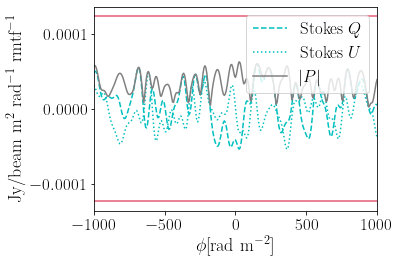

In [77]:
plt.plot(parameter.phi, residual_faraday.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, residual_faraday.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(residual_faraday), '-', c='grey', label=r"$|P|$")
#plt.plot([-200.,-200.],[0.,0.0035],ls='-',lw=2.,c='black')
#plt.plot(parameter.phi,np.zeros(len(parameter.phi)),ls='-',lw=2.,c='black')
plt.axhline(y=5 * dataset.theo_noise, color='crimson', alpha=0.7)
plt.axhline(y=-5 * dataset.theo_noise, color='crimson', alpha=0.7)
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000, 1000])
plt.tight_layout()
#plt.savefig("fds_sim1.png", dpi=100)

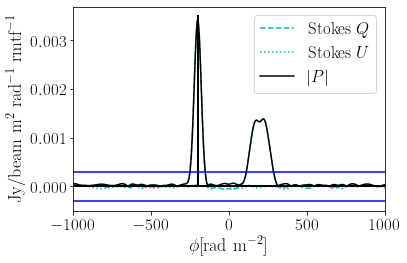

In [78]:
plt.plot(parameter.phi, conv_model.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, conv_model.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(conv_model), 'k-', label=r"$|P|$")
plt.plot([-200., -200.], [0., 0.0035], ls='-', lw=2., c='black')
plt.plot(parameter.phi, np.zeros(len(parameter.phi)), ls='-', lw=2., c='black')
plt.xlim([-1000, 1000])
plt.axhline(y=5 * noise_F, color='b')
plt.axhline(y=-5 * noise_F, color='b')
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig("restored.png", dpi=100)

In [79]:
np.nanmax(np.abs(conv_model))

0.00340314071915468

In [80]:
P = np.sqrt(np.max(np.abs(conv_model))**2 - (2.3 * rms_residual**2))

In [81]:
parameter.rmtf_fwhm / (2 * P / rms_residual)

0.18232576996522376

In [82]:
residual_1d = np.concatenate([residual_faraday.real, residual_faraday.imag])
#residual_1d = np.concatenate([dataset.residual.real, dataset.residual.imag])
stat, p = stats.jarque_bera(residual_1d)

In [83]:
print("stat={0:.3f}, p={1:.3f}".format(stat, p))

stat=29.299, p=0.000


In [84]:
p

4.342860756567646e-07

In [85]:
if p > 0.05:
    print("Probably Gaussian")
else:
    print("Probably not Gaussian")

Probably not Gaussian


In [86]:
residual_all = np.concatenate([F_residual.real, F_residual.imag]) * 1000.0

In [87]:
frequency, bins = np.histogram(residual_all, bins="auto", density=True)
frequency /= np.max(frequency)
xmin = np.min(bins)
xmax = np.max(bins)
dist = np.abs(xmax - xmin)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, 0.0, dataset.theo_noise * 1000.0)
p /= np.max(p)

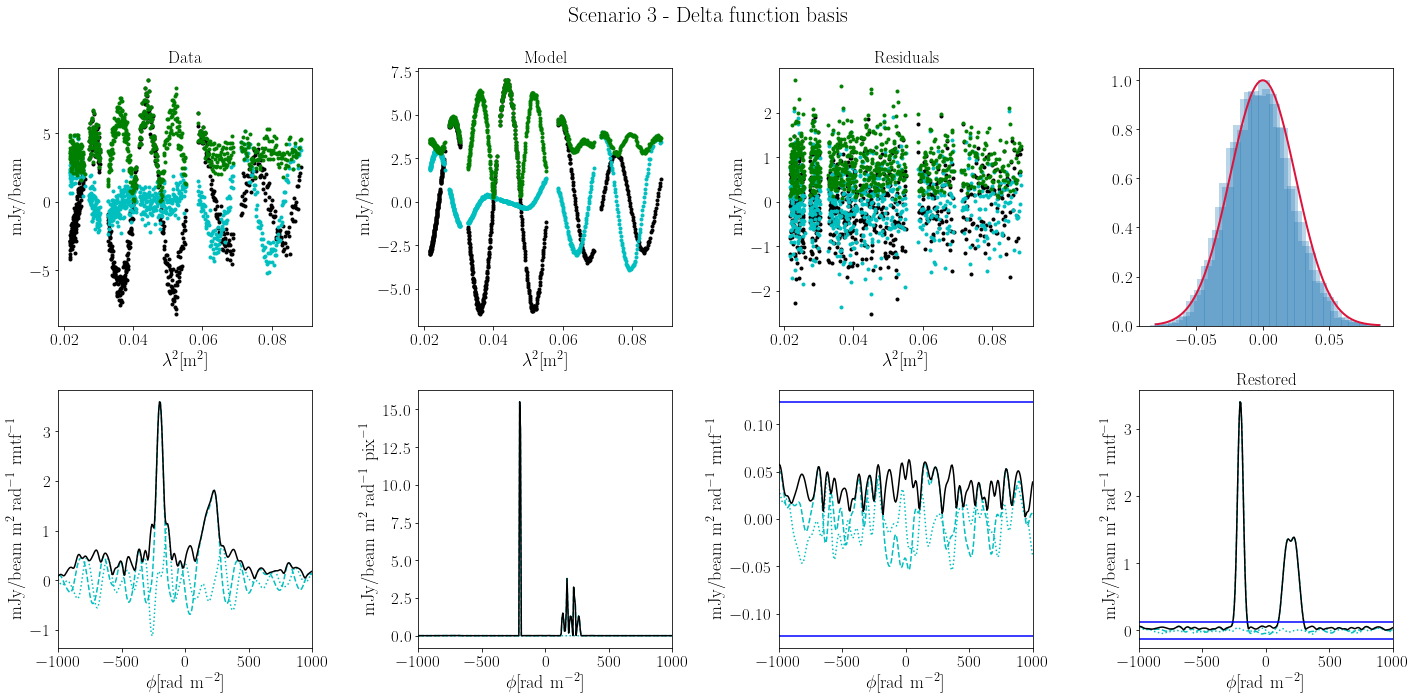

In [88]:
fig, ax = plt.subplots(nrows=2, ncols=4, sharex='row', figsize=(20, 10))

# Data
ax[0, 0].plot(dataset.lambda2, dataset.data.real * 1000.0, 'k.', label=r"Stokes $Q$")
ax[0, 0].plot(dataset.lambda2, dataset.data.imag * 1000.0, 'c.', label=r"Stokes $U$")
ax[0, 0].plot(dataset.lambda2, np.abs(dataset.data) * 1000.0, 'g.', label=r"$|P|$")
ax[0, 0].set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax[0, 0].set_ylabel(r'mJy/beam')
ax[0, 0].title.set_text("Data")

ax[1, 0].plot(parameter.phi, F_dirty.real * 1000.0, 'c--', label=r"Stokes $Q$")
ax[1, 0].plot(parameter.phi, F_dirty.imag * 1000.0, 'c:', label=r"Stokes $U$")
ax[1, 0].plot(parameter.phi, np.abs(F_dirty) * 1000.0, 'k-', label=r"|P|")
ax[1, 0].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1, 0].set_ylabel(r'mJy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[1, 0].set_xlim([-1000, 1000])

# Model
ax[0, 1].plot(dataset.lambda2, dataset.model_data.real * 1000.0, 'k.', label=r"Stokes $Q$")
ax[0, 1].plot(dataset.lambda2, dataset.model_data.imag * 1000.0, 'c.', label=r"Stokes $U$")
ax[0, 1].plot(dataset.lambda2, np.abs(dataset.model_data) * 1000.0, 'g.', label=r"$|P|$")
ax[0, 1].set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax[0, 1].set_ylabel(r'mJy/beam')
ax[0, 1].title.set_text("Model")
# Model
ax[1, 1].plot(parameter.phi, X.data.real * 1000.0, 'c--', label=r"Stokes $Q$")
ax[1, 1].plot(parameter.phi, X.data.imag * 1000.0, 'c:', label=r"Stokes $U$")
ax[1, 1].plot(parameter.phi, np.abs(X.data) * 1000.0, 'k-', label=r"$|P|$")
ax[1, 1].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1, 1].set_ylabel(r'mJy/beam m$^2$ rad$^{-1}$ pix$^{-1}$')
ax[1, 1].set_xlim([-1000, 1000])

# Residual

ax[0, 2].plot(dataset.lambda2, dataset.residual.real * 1000.0, 'k.', label=r"Stokes $Q$")
ax[0, 2].plot(dataset.lambda2, dataset.residual.imag * 1000.0, 'c.', label=r"Stokes $U$")
ax[0, 2].plot(dataset.lambda2, np.abs(dataset.residual) * 1000.0, 'g.', label=r"$|P|$")
ax[0, 2].set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax[0, 2].set_ylabel(r'mJy/beam')
ax[0, 2].title.set_text("Residuals")

ax[0, 3].get_shared_x_axes().remove(ax[0, 3])
# Create and assign new ticker
xticker = matplotlib.axis.Ticker()
ax[0, 3].xaxis.major = xticker

# The new ticker needs new locator and formatters
xloc = matplotlib.ticker.AutoLocator()
xfmt = matplotlib.ticker.ScalarFormatter()

ax[0, 3].xaxis.set_major_locator(xloc)
ax[0, 3].xaxis.set_major_formatter(xfmt)

ax[0, 3].bar(bins[:-1], frequency, width=dist / 20, alpha=0.3)
ax[0, 3].plot(x, p, 'crimson', linewidth=2)

ax[1, 2].plot(parameter.phi, F_residual.real * 1000.0, 'c--', label=r"Stokes $Q$")
ax[1, 2].plot(parameter.phi, F_residual.imag * 1000.0, 'c:', label=r"Stokes $U$")
ax[1, 2].plot(parameter.phi, np.abs(F_residual) * 1000.0, 'k-', label=r"$|P|$")
ax[1, 2].axhline(y=5 * dataset.theo_noise * 1000.0, color='b')
ax[1, 2].axhline(y=-5 * dataset.theo_noise * 1000.0, color='b')
ax[1, 2].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1, 2].set_ylabel(r'mJy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[1, 2].set_xlim([-1000, 1000])

ax[1, 3].plot(parameter.phi, conv_model.real * 1000.0, 'c--', label=r"Stokes $Q$")
ax[1, 3].plot(parameter.phi, conv_model.imag * 1000.0, 'c:', label=r"Stokes $U$")
ax[1, 3].plot(parameter.phi, np.abs(conv_model) * 1000.0, 'k-', label=r"$|P|$")
ax[1, 3].axhline(y=5 * dataset.theo_noise * 1000.0, color='b')
ax[1, 3].axhline(y=-5 * dataset.theo_noise * 1000.0, color='b')
ax[1, 3].set_xlim([-1000, 1000])
ax[1, 3].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1, 3].set_ylabel(r'mJy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[1, 3].title.set_text("Restored")

title = "Scenario 3 - "
"""
if isinstance(dataset, FaradayThinSource):
    title += "Scenario 1 - "
elif isinstance(dataset, FaradayThickSource):
    title += "Scenario 2 - "
else:
    title += "Scenario 3 - "
"""
if wav is None:
    title += "Delta function basis "
else:
    if isinstance(wav, DiscreteWavelet):
        if wav.append_signal is True:
            title += "Delta function basis + {0} discrete wavelet ".format(wav.wavelet_name)
        else:
            title += "{0} discrete wavelet ".format(wav.wavelet_name)
    else:
        if wav.append_signal is True:
            title += "Delta function basis + {0} undecimated wavelet ".format(wav.wavelet_name)
        else:
            title += "{0} undecimated wavelet ".format(wav.wavelet_name)
"""
if wav is None:
    title += "- Delta function basis "
else:
    if isinstance(wav, DiscreteWavelet):
        if wav.append_signal is True:
            title += "- Delta function basis + {0} discrete wavelet ".format(wav.wavelet_name)
        else:
            title += "- {0} discrete wavelet ".format(wav.wavelet_name)
    else:
        if wav.append_signal is True:
            title += "- Delta function basis + {0} undecimated wavelet ".format(wav.wavelet_name)
        else:
            title += "- {0} undecimated wavelet ".format(wav.wavelet_name)

if (dataset.w == dataset.w[0]).all():
    title += "uniform weights equal to {0:.3f}".format(dataset.w[0])   
else:
    title += "natural weights "




"""
fig.suptitle(title)
fig.tight_layout()

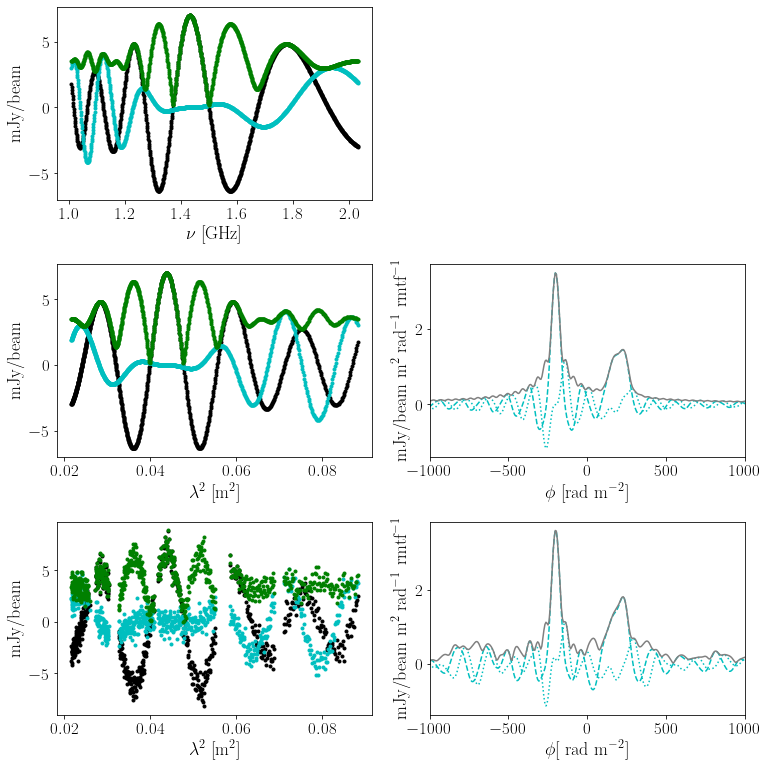

In [89]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(11, 11))
ax[0, 0].plot(
    original_source.nu[::-1] / 1e9,
    original_source.data[::-1].real * 1000.0,
    'k.',
    label=r"Stokes $Q$"
)
ax[0, 0].plot(
    original_source.nu[::-1] / 1e9,
    original_source.data[::-1].imag * 1000.0,
    'c.',
    label=r"Stokes $U$"
)
ax[0, 0].plot(
    original_source.nu[::-1] / 1e9,
    np.abs(original_source.data[::-1]) * 1000.0,
    'g.',
    label=r"$|P|$"
)
ax[0, 0].set_xlabel(r'$\nu$ [GHz]')
ax[0, 0].set_ylabel(r'mJy/beam')

#hide x-axis
#ax.get_xaxis().set_visible(False)

#hide y-axis
#ax.get_yaxis().set_visible(False)
ax[0, 1].get_xaxis().set_visible(False)
ax[0, 1].get_yaxis().set_visible(False)
ax[0, 1].set_frame_on(False)

ax[1,
   0].plot(original_source.lambda2, original_source.data.real * 1000.0, 'k.', label=r"Stokes $Q$")
ax[1,
   0].plot(original_source.lambda2, original_source.data.imag * 1000.0, 'c.', label=r"Stokes $U$")
ax[1, 0].plot(original_source.lambda2, np.abs(original_source.data) * 1000.0, 'g.', label=r"$|P|$")
ax[1, 0].set_xlabel(r'$\lambda^2$ [m$^{2}$]')
ax[1, 0].set_ylabel(r'mJy/beam')

ax[1, 1].plot(original_parameter.phi, F_dirty_original.real * 1000.0, 'c--', label=r"Stokes $Q$")
ax[1, 1].plot(original_parameter.phi, F_dirty_original.imag * 1000.0, 'c:', label=r"Stokes $U$")
ax[1,
   1].plot(original_parameter.phi, np.abs(F_dirty_original) * 1000.0, '-', c='grey', label=r"|P|")
#ax[1,1].plot([-200., -200.], [0., 0.0035], ls='-', lw=2., c='black')
#ax[1,1].plot(original_parameter.phi, np.zeros(len(original_parameter.phi)), ls='-', lw=2., c='black')
ax[1, 1].set_xlabel(r'$\phi$ [rad m$^{-2}$]')
ax[1, 1].set_ylabel(r'mJy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
#ax[1,1].legend(loc='upper right')
ax[1, 1].set_xlim([-1000, 1000])

ax[2, 0].plot(dataset.lambda2, dataset.data.real * 1000.0, 'k.', label=r"Stokes $Q$")
ax[2, 0].plot(dataset.lambda2, dataset.data.imag * 1000.0, 'c.', label=r"Stokes $U$")
ax[2, 0].plot(dataset.lambda2, np.abs(dataset.data) * 1000.0, 'g.', label=r"$|P|$")
ax[2, 0].set_xlabel(r'$\lambda^2$ [m$^{2}$]')
ax[2, 0].set_ylabel(r'mJy/beam')

ax[2, 1].plot(parameter.phi, F_dirty.real * 1000.0, 'c--', label=r"Stokes $Q$")
ax[2, 1].plot(parameter.phi, F_dirty.imag * 1000.0, 'c:', label=r"Stokes $U$")
ax[2, 1].plot(parameter.phi, np.abs(F_dirty) * 1000.0, '-', c='grey', label=r"|P|")
ax[2, 1].set_xlabel(r'$\phi$[ rad m$^{-2}$]')
ax[2, 1].set_ylabel(r'mJy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[2, 1].set_xlim([-1000, 1000])

fig.tight_layout()

fig.savefig("example_ursi.pdf", dpi=100)